Enter file name (sample files are sudoku1.png, sudoku2.png, and sudoku3.png): sudoku1.png


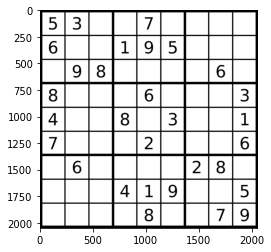

In [430]:
#Matthew Ennis C18477502
#Project: Sudoku Solver

import cv2
from matplotlib import pyplot as plt
import numpy as np

filename = input("Enter file name (sample files are sudoku1.png, sudoku2.png, and sudoku3.png): ")

original = cv2.imread(filename)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.imshow(original);

210.0667712688446


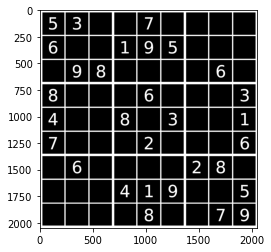

In [431]:
#First the sudoku is made into a binary image
#This is done using the mean as a threshold
#The threshold really doesn't matter much since the image is black and white anyway
#Pretty much anything between 0 and 255 would work
#The image is then inverted to make the next steps easier

gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
thresh = np.mean(gray)
print(thresh)

t, sudoku = cv2.threshold(gray, thresh=thresh, maxval=255, type=cv2.THRESH_BINARY)

sudoku = cv2.bitwise_not(sudoku)

plt.imshow(sudoku, cmap="gray");

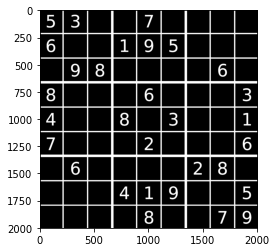

In [432]:
#The border of the image is cropped out by removing any rows/columns of pixels where the min and max is the same
#If min and max are the same then it's a row of all black or all white and should be removed

def crop(img):
    while np.min(img[0,:]) == np.max(img[0,:]):
        img = img[1:,:]
    while np.min(img[-1,:]) == np.max(img[-1,:]):
        img = img[:-2,:]
    while np.min(img[:,0]) == np.max(img[:,0]):
        img = img[:,1:]
    while np.min(img[:,-1]) == np.max(img[:,-1]):
        img = img[:,:-2]
    return img

sudoku = crop(sudoku)
h, w = sudoku.shape
plt.imshow(sudoku,cmap="gray");

In [433]:
#Next, I find the x co-ordinates where a pixel changes from black to white or white to black
#This gives me the start and end of each cell of the sudoku grid

prev = 255
loc = 0
squaresx = []
for pixel in sudoku[0,:]:
    if pixel != prev:
        squaresx.append(loc)
    prev = pixel
    loc += 1
squaresx.append(loc)
print(squaresx)

[0, 206, 218, 431, 443, 652, 675, 881, 893, 1106, 1118, 1327, 1350, 1556, 1568, 1781, 1793, 2001]


In [434]:
#The same thing is done again but for y co-ordinates

prev = 255
loc = 0
squaresy = []
for pixel in sudoku[:,0]:
    if pixel != prev:
        squaresy.append(loc)
    prev = pixel
    loc += 1
squaresy.append(loc)
print(squaresy)

[0, 210, 222, 435, 447, 652, 675, 885, 897, 1110, 1122, 1327, 1350, 1561, 1573, 1786, 1797, 2001]


[[1. 2. 0. 0. 3. 0. 0. 0. 0.]
 [4. 0. 0. 5. 6. 1. 0. 0. 0.]
 [0. 6. 7. 0. 0. 0. 0. 4. 0.]
 [7. 0. 0. 0. 4. 0. 0. 0. 2.]
 [8. 0. 0. 7. 0. 2. 0. 0. 5.]
 [3. 0. 0. 0. 9. 0. 0. 0. 4.]
 [0. 4. 0. 0. 0. 0. 9. 7. 0.]
 [0. 0. 0. 8. 5. 6. 0. 0. 1.]
 [0. 0. 0. 0. 7. 0. 0. 3. 6.]]


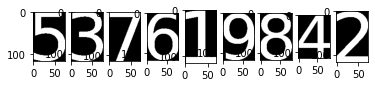

In [435]:
#This is the most complex step
#First I create an empty array of "uniques" and a 9 by 9 grid of zeros
#I then iterate through each cell of the sudoku using the co-ordinates found in the previous steps
#The cropping method from earlier is used to crop the cell to just the number part
#I then XOR that number image with all of the images in the uniques array
#If the XOR has very few white pixels then the number is probably already in uniques
#Otherwise it's a new number and is added to uniques
#Once the number is in uniques, it's index is added to the grid of zeros in the correct place
#By the end of this process there should be 9 distinct images in uniques
#The grid will now resemble the actual sudoku but with different numbers
#For example, a 1 in the grid represents the first number in uniques

uniques = []
grid = np.zeros((9,9))

for row in range(9):
    for col in range(9):
        try:
            cell = crop(sudoku[squaresy[row*2]:squaresy[row*2+1],squaresx[col*2]:squaresx[col*2+1]])
        except:
            continue
        matched = False
        for i in range(len(uniques)):
            uh, uw = uniques[i].shape
            ch, cw = cell.shape
            mh = min(uh,ch)
            mw = min(uw,cw)
            diff = cv2.bitwise_xor(cell[:mh,:mw],uniques[i][:mh,:mw])
            if cv2.countNonZero(diff) <= (mh*mw) // 20:
                matched = True
                grid[row,col] = i+1
                break
        if not matched:
            uniques.append(cell)
            grid[row,col] = len(uniques)

for i in range(len(uniques)):
    plt.subplot(1,len(uniques),i+1)
    plt.imshow(uniques[i], cmap="gray")

if len(uniques) != 9:
    print("Unable to solve this sudoku")
else:
    print(grid)

In [436]:
#In this step, the actual puzzle is solved
#I use a simple recursive brute force algorithm to solve it
#Brute force may seem inefficient but it's a small enough puzzle so it solves quickly regardless
#By the end of this step, we have a fully solved grid

def solve(grid, cell):
    if cell == 81:
        return True
    x = cell // 9
    y = cell % 9
    if grid[x,y] != 0:
        if solve(grid,cell+1):
            return True
    else:
        for i in range(1,10):
            if check(grid, i, x, y):
                grid[x,y] = i
                if solve(grid, cell+1):
                    return True
        grid[x,y] = 0
    return False

def check(grid, num, x, y):
    if num in grid[x,:] or num in grid[:,y]:
        return False
    boxx = (x//3)*3
    boxy = (y//3)*3
    if num in grid[boxx:boxx+3,boxy:boxy+3]:
        return False
    return True

unsolvedgrid = np.copy(grid)
solve(grid, 0)
print(grid)

[[1. 2. 8. 4. 3. 7. 6. 5. 9.]
 [4. 3. 9. 5. 6. 1. 2. 8. 7.]
 [5. 6. 7. 2. 8. 9. 1. 4. 3.]
 [7. 1. 6. 3. 4. 5. 8. 9. 2.]
 [8. 9. 4. 7. 1. 2. 3. 6. 5.]
 [3. 5. 2. 6. 9. 8. 7. 1. 4.]
 [6. 4. 5. 1. 2. 3. 9. 7. 8.]
 [9. 7. 3. 8. 5. 6. 4. 2. 1.]
 [2. 8. 1. 9. 7. 4. 5. 3. 6.]]


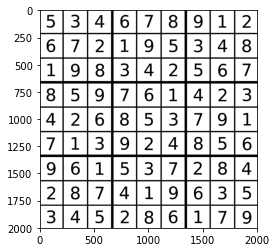

In [437]:
#In the final step, the solved grid is used to place the numbers from the uniques array into their rightful places
#I use the x and y co-ordinates from earlier and the height and width of the numbers to make sure they look right

for x in range(9):
    for y in range(9):
        if unsolvedgrid[x,y] != 0:
            continue
        num = uniques[int(grid[x,y])-1]
        nh, nw = num.shape
        xstart = squaresx[y*2] + ((squaresx[y*2+1]-squaresx[y*2]-nw) // 2)
        ystart = squaresy[x*2] + ((squaresy[x*2+1]-squaresy[x*2]-nh) // 2)
        sudoku[ystart:ystart+nh,xstart:xstart+nw] = num

sudoku = cv2.bitwise_not(sudoku)
plt.imshow(sudoku, cmap="gray");

In [438]:
cv2.imwrite("solved_"+filename, sudoku)
print("Your new file can be found at solved_"+filename)

Your new file can be found at solved_sudoku1.png
